## Load lib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyramses

## Load Models

In [2]:
from agc_models import end_simulation
from agc_models import move_file
from agc_models import sfc
from agc_models import Gens
from agc_models import sortGens
from agc_models import multipleIncreaseDelay

from agc_models import chop_curve
from agc_models import settling_time
from agc_models import rate_of_change
from agc_models import max_rate_of_change

## Load a simulator instance

In [3]:
ram = pyramses.sim()

## Load saved test-case & Add more observation(s)

In [4]:
case = pyramses.cfg('cmd.txt')
case.addRunObs('MS CCGTG2.01')  # Monitor, will write real-time (voltage-time or) frequency-time data of bus G2 (GBdynHVDC.dat)
monitor = ['CCGTG2.01']

## Universe Parameters (relative fixed)

In [5]:
prepared_folder_address = 'cur' # 'D:/OneDrive - University of Leeds/cur'
nominal_frequency = 1.0
start_time = 300.0
settling_end_time = 1200.0
end_time = 1500.0  # (dst file)
agcTimeStep = 1.0

## Breaker (one of distrubances) & Selected generators (to help fix errors)

In [6]:
breaker = 'CCGTG21.01' # (dst file)

# gen's code     name       weight  mini delay              
gen15_2 = Gens('COALG15.02', 0.161, 0.0615)  # 8027.401/27580.102 = 0.291
gen16_1 = Gens('CCGTG16.01', 0.226, 0.1220)  # 7631.982/27580.102 = 0.277
gen17_2 = Gens('COALG17.02', 0.161, 0.1221)  # 2240.000/27580.102 = 0.081
gen23_1 = Gens('CCGTG23.01', 0.226, 0.0609)  # 5716.446/27580.102 = 0.207
gen26_1 = Gens('CCGTG26.01', 0.226, 0.0602)  # 3964.273/27580.102 = 0.143
liST = []
liST.append(gen15_2)
liST.append(gen16_1)
liST.append(gen17_2)
liST.append(gen23_1)
liST.append(gen26_1)

list_of_gens, weight_of_gens,  mini_list_of_td = sortGens(liST)
print(list_of_gens)
print(weight_of_gens)
print(mini_list_of_td)

['CCGTG26.01', 'CCGTG23.01', 'COALG15.02', 'CCGTG16.01', 'COALG17.02']
[0.226, 0.226, 0.161, 0.226, 0.161]
[0.0602, 0.0609, 0.0615, 0.122, 0.1221]


## trj.csv title

In [7]:
trj_kp = []
trj_ki = []
trj_max_15_2 = []
trj_max_16_1 = []
trj_max_17_2 = []
trj_max_23_1 = []
trj_max_26_1 = []
trj_exceedOrNot = []

## cur.csv title

In [8]:
KP = []
KI = []
PCGTD = []
SETTLINGTIME = []

## Test with fixed kp and ki

In [ ]:
# change the size of graph
plt.figure(figsize=(20,10))


if __name__ == '__main__':
    for kp in np.arange(0.10, 3.11, 0.1):  # 0.1-3.1, 0.1
        for ki in np.arange(0.010, 0.081, 0.010): # 0.01-0.08, 0.01
            for pcgTd in np.arange(100, 1000.1, 450): # 100, 550, 1000 (%)
                list_of_td = multipleIncreaseDelay(pcgTd, mini_list_of_td)
                
                kp = "{0:.4f}".format(round(float(kp),4))
                ki = "{0:.4f}".format(round(float(ki),4))
                print("kp = " + str(kp))
                print("ki = " + str(ki))
                print("deley = " + str(pcgTd) + "% of mini")
                print(list_of_td)
                
                
                # run agc
                sfc(ram, case, monitor, list_of_gens, weight_of_gens, list_of_td, prepared_folder_address, start_time, end_time, agcTimeStep, breaker, nominal_frequency, kp, ki)
                
                
                # clear td's list
                list_of_td = []
                print("clear list_of_td\n")
                
                
                # Embed the frequency/voltage response in the output
                ext = pyramses.extractor(case.getTrj())
                trj_kp.append(float(kp))
                trj_ki.append(float(ki))
                max_15_2 = max_rate_of_change(ext.getSync('COALG15.02').P.time, ext.getSync('COALG15.02').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)
                max_16_1 = max_rate_of_change(ext.getSync('CCGTG16.01').P.time, ext.getSync('CCGTG16.01').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)
                max_17_2 = max_rate_of_change(ext.getSync('COALG17.02').P.time, ext.getSync('COALG17.02').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)
                max_23_1 = max_rate_of_change(ext.getSync('CCGTG23.01').P.time, ext.getSync('CCGTG23.01').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)
                max_26_1 = max_rate_of_change(ext.getSync('CCGTG26.01').P.time, ext.getSync('CCGTG26.01').P.value, start_time, settling_end_time, agcTimeStep, unit_converter=60)


                trj_max_15_2.append(max_15_2)
                trj_max_16_1.append(max_16_1)
                trj_max_17_2.append(max_17_2)
                trj_max_23_1.append(max_23_1)
                trj_max_26_1.append(max_26_1)
                
                
                if max_15_2 >= 0.05 * 6823.291 or max_16_1 >= 0.10 * 6868.783 or max_17_2 >= 0.05 * 1904.000 or max_23_1 >= 0.10 * 4858.979 or max_26_1 >= 0.10 * 3567.846:
                    trj_exceedOrNot.append("Exceed")
                else:
                    trj_exceedOrNot.append("Not Exceed")
                    
                    
                    # unchopped curve
                    t_ori = ext.getSync('CCGTG2.01').S.time
                    f_ori = ext.getSync('CCGTG2.01').S.value
                    
                    
                    # chop curve
                    t_ori, f_ori, t, f = chop_curve(t_ori, f_ori, chop_value=300)
                    
                    
                    # find settling time
                    settlingTime = settling_time(t, f, 1/5000, nominal_frequency)
                    
                    
                    # curve's label
                    strLabel = "kp = " + str(kp) + ", ki = " + str(ki) + ", td = " + str(pcgTd) + "% mini" + ", settling time = " + str(settlingTime) + " sec"
                    
                    
                    # filter stable cases
                    if max(f) <= 1.004 and settlingTime <= 1200:
                        # put data into lists
                        KP.append(float(kp))
                        KI.append(float(ki))
                        PCGTD.append(float(pcgTd))
                        SETTLINGTIME.append(float(settlingTime))

                        # plot
                        plt.plot(t, f, label=strLabel)
                        plt.legend()
                        plt.xlabel('time (sec)')
                        plt.ylabel('frequency (pμ)')
                        plt.title("f-t curve(s)")
                        plt.grid(True)

                        # plot one by one (if needed)
                        # plt.show()

## Stable cases

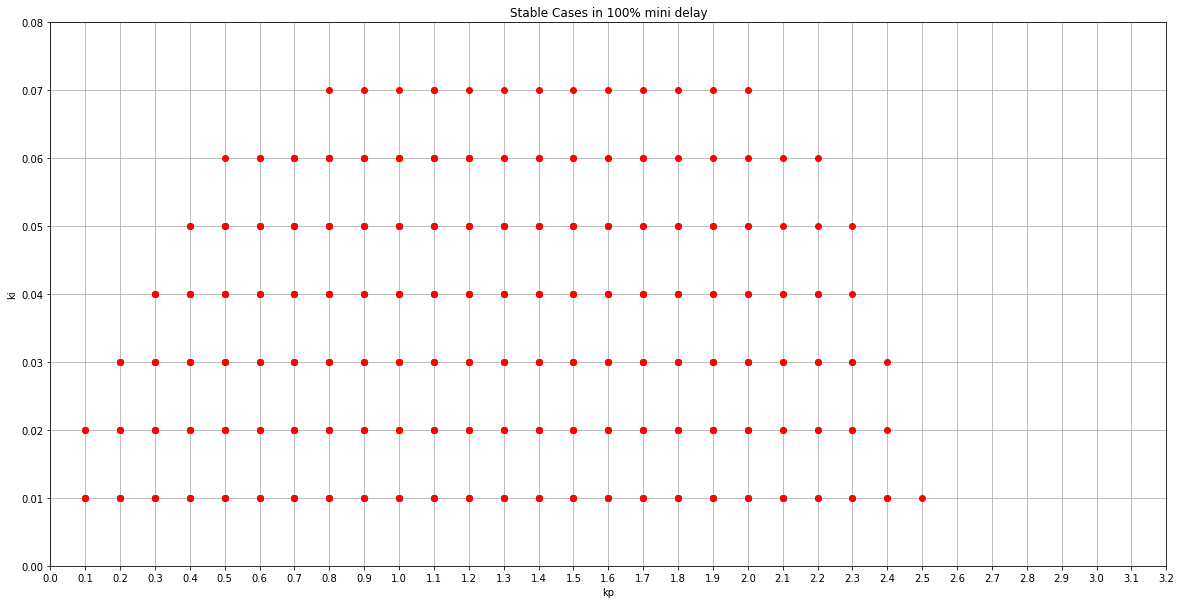

In [10]:
fig = plt.figure(figsize=(20,10))
plt.plot(KP,KI,'ro')
plt.axis([0, 3.2, 0, 0.08])
plt.xticks(np.arange(0,3.21,0.1))
plt.xlabel('kp')
plt.ylabel('ki')
plt.title("Stable Cases in 100% mini delay")
plt.grid(True)

## trj.csv

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyramses

df = pd.DataFrame.from_dict({'kp':trj_kp, 'ki':trj_ki, 'Max power rate of G15.02 (max=341.165MW/min)':trj_max_15_2, 
                                                       'Max power rate of G16.01 (max=686.878MW/min)':trj_max_16_1, 
                                                       'Max power rate of G17.02 (max=95.200MW/min)':trj_max_17_2, 
                                                       'Max power rate of G23.01 (max=485.898MW/min)':trj_max_23_1,
                                                       'Max power rate of G26.01 (max=356.785MW/min)':trj_max_26_1,
                                                       'Exceed max power rate or not?': trj_exceedOrNot})
df.to_csv('trj.csv', header=True, index=False)

## cur.csv

In [12]:
df = pd.DataFrame.from_dict({'kp':KP, 'ki':KI, 'pcgTd (%)':PCGTD, 'settling time (sec)':SETTLINGTIME})
df.to_csv('cur.csv', header=True, index=False)